After rewriting/refactoring of code base, do a test pipeline from start to end to see if everything works in principle.

In [23]:
import logging
import os
from pathlib import Path

import importlib

In [24]:
logger = logging.getLogger()
logger.setLevel(logging.DEBUG)
SEED = 42

In [25]:
from modules import SequenceRepresentation as sr
from modules import ModelDataSet
from modules import ProfileFindingSetup
from modules import plotting
from modules import model
from modules import training
from modules import Links
from modules import Streme

importlib.reload(sr)
importlib.reload(ModelDataSet)
importlib.reload(ProfileFindingSetup)
importlib.reload(plotting)
importlib.reload(model)
importlib.reload(Links)
importlib.reload(Streme)

<module 'modules.Streme' from '/home/ebelm/genomegraph/learn_specific_profiles/modules/Streme.py'>

In [26]:
datapath = Path("/home/ebelm/genomegraph/data/241_species/20231123_subset150_NM_RefSeqBest/20240605_fixed_out_subset150_withEnforced_20_15_20_50_15_20_15_20_mammals/exon_chr10_100356531_100356764/")
outpath  = Path("/home/ebelm/genomegraph/runs/20240605_testNewModel/")
os.makedirs(outpath, exist_ok=True)

In [27]:
sequences = sr.loadJSONSequenceList(datapath / "profile_finding_sequence_data.json")
datamode = ModelDataSet.DataMode.DNA

In [28]:
genomes: list[sr.Genome] = []
for seq in sequences:
    # make annotations and transkripts unique
    sr.makeAnnotationsUnique(seq)
    sr.selectLongestTranscript(seq)
    #seq.removeSoftmasking()

    g = sr.Genome()
    g.addSequence(seq)
    genomes.append(g)

INFO:root:[makeAnnotationsUnique] Sequence Fukomys_damarensis:KN123008.1:2,409,178-2,440,546: Found and uniq-ed 0 redundant annotations; removed total of 0 redundant annotations
INFO:root:[selectLongestTranscript] Found and removed subsequence annotations in {sequence}. Removed total of 0 subsequence annotations
INFO:root:[makeAnnotationsUnique] Sequence Cercocebus_atys:KQ012652.1:5,274,598-5,280,660: Found and uniq-ed 1 redundant annotations; removed total of 1 redundant annotations
INFO:root:[makeAnnotationsUnique] Sequence Saimiri_boliviensis:JH378110.1:32,223,310-32,229,802: Found and uniq-ed 1 redundant annotations; removed total of 1 redundant annotations
INFO:root:[makeAnnotationsUnique] Sequence Hipposideros_armiger:JXIK01000029.1:2,457,613-2,462,101: Found and uniq-ed 0 redundant annotations; removed total of 0 redundant annotations
INFO:root:[selectLongestTranscript] Found and removed subsequence annotations in {sequence}. Removed total of 1 subsequence annotations


In [29]:
# # debug: overwrite genomes
# dbg_datapath = Path("/home/ebelm/genomegraph/runs/20240628_modelVsStreme_newCodebaseTest_cpu/0034_singleExonGenomes.json")
# genomes = sr.loadJSONGenomeList(dbg_datapath)

In [30]:
# shorten data so that it runs faster
maxgenomes = 5
maxseqlen = 3000

genomes = genomes[:maxgenomes]
for genome in genomes:
    for seq in genome.sequences:
        if len(seq) > maxseqlen:
            d = len(seq) - maxseqlen
            seq.stripSequence(d, from_start=False)

In [31]:
# # store shortened data as test genomes for unittests
# with open("/home/ebelm/genomegraph/learn_specific_profiles/tests/testdata.json", 'wt') as fh:
#     json.dump([g.toList() for g in genomes], fh, indent=2)

In [32]:
runID = "0000"
logging.info(f"[main] Start training and evaluation for run {runID}")

# --- train our model (DNA mode) ---
logging.info(f"[main] Start training and evaluation on model for {runID}")
data = ModelDataSet.ModelDataSet(genomes, datamode,
                                 tile_size = 334, tiles_per_X = 7, batch_size = 1, prefetch = 3)
trainsetup = ProfileFindingSetup.ProfileFindingTrainingSetup(data, 
                                                             U = 200, 
                                                             k = 20,
                                                             midK = 12,
                                                             s = 0,
                                                             epochs = 350,
                                                             gamma = 1,
                                                             l2 = 0.01,
                                                             match_score_factor = 0.7,
                                                             learning_rate = 2,
                                                             lr_patience = 5,
                                                             lr_factor = 0.75,
                                                             rho = 0,
                                                             sigma = 1,
                                                             profile_plateau = 10,
                                                             profile_plateau_dev = 150,
                                                             n_best_profiles=2,
                                                             phylo_t = 0)
trainsetup.initializeProfiles_kmers(enforceU=False, minU=10, minOcc=8, overlapTilesize=6,  plot=False)
evaluator = training.MultiTrainingEvaluation()
# try:
training.trainAndEvaluate(runID, trainsetup, evaluator, 
                          outpath, outprefix=f"{runID}_", 
                          rand_seed=SEED)

evaluator.dump(outpath / "evaluator.json")

INFO:root:[main] Start training and evaluation for run 0000
INFO:root:[main] Start training and evaluation on model for 0000


INFO:root:[ProfileFindingSetup.ProfileFindingTrainingSetup.initializeProfiles] >>> Number of profiles: 10
DEBUG:root:[model.__init__] >>> setting tf global seed to 42
DEBUG:root:[model.__init__] >>> Using initProfiles from training setup instead of random
2024-07-12 16:48:43.864975: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-07-12 16:48:44.004928: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-07-12 16:48:44.128943: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
DEBUG:root:[model.train.setLR] >>> Setting learning rate to 2
DEBUG:root:[model.getR] >>> nan in P: Tensor("cond/Any:0", shape=(10,), dtype=bool) Tensor("cond/boolean_mask/GatherV2:0", shape=(20, 4, None), dtype=float32)
DEBUG:root:[model.getR] >>> Q: [0.2664765  0.23352347 0.23352347

INFO:root:[main] Start training and evaluation on STREME for 0000
INFO:root:Creating working directory /home/ebelm/genomegraph/runs/20240605_testNewModel/0000_STREME.
INFO:root:STREME took 1.75 seconds.
INFO:root:STREME output: Running 'streme  --p data.fasta --o streme_out --dna --nmotifs 2 --minw 20 --maxw 20'
# Warning: No hold-out set was created because the primary hold-out set 
#          would have had fewer than 5 sequences.
# Positive sequences "data.fasta" - training: 10 hold-out: 0
# Negative sequences are shuffled primary sequences (2-order) - training: 10 hold-out: 0
# Estimating background model from control sequences.
# Background: A 0.27 C 0.231 G 0.231 T 0.27
# Background order: 2 Background size: 84
# Using Fisher Exact test for p-values.
# Building suffix tree of positive and negative sequences...
# SUFFIXTREE	0.00 seconds 	(cumulative 0.02 seconds)
# Adding sequence counts and p-values to nodes using depth first search...
# ADDCOUNTS	0.00 seconds 	(cumulative 0.09 s

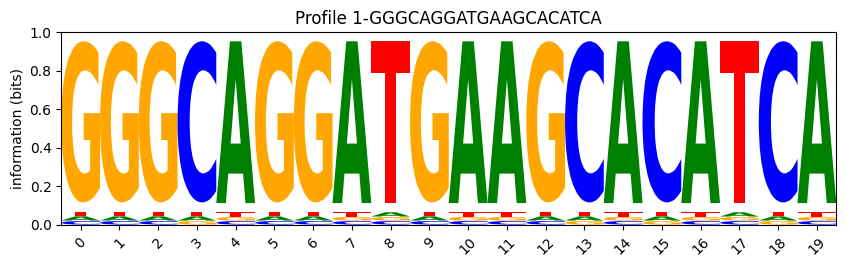

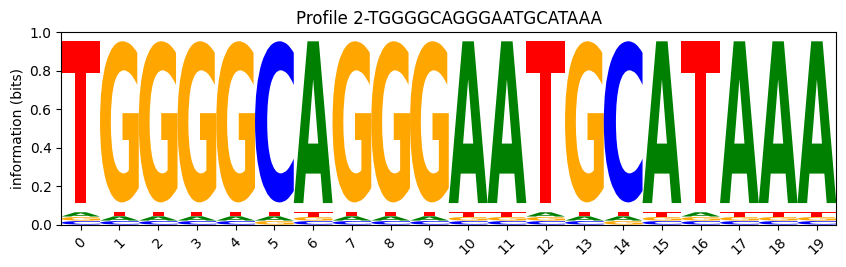

In [33]:
logging.info(f"[main] Start training and evaluation on STREME for {runID}")
streme_wd = outpath / f"{runID}_STREME"
if os.path.exists(streme_wd):
    os.system(f"rm -r {streme_wd}")

streme_runner = Streme.Streme(working_dir = streme_wd,
                              k_min = 20,
                              k_max = 20,
                              n_best_motifs = 2,
                              load_streme_script= "/home/ebelm/Software/load_MEME.sh")
data = ModelDataSet.ModelDataSet(genomes, datamode,
                                 tile_size = 334, tiles_per_X = 7, batch_size = 1, prefetch = 3)
streme_evaluator = training.MultiTrainingEvaluation()

try:
    _ = streme_runner.run(runID, data, streme_evaluator, verbose=True, plot_motifs=True, plot_links=True, plot_onlyLinkedSeqs=False)
except Exception as e:
    logging.error(f"[main] STREME failed for homology {0}, check log for details")
    logging.error(f"[main] Error message: {e}")

    def full_stack():
        import traceback, sys
        exc = sys.exc_info()[0]
        stack = traceback.extract_stack()[:-1]  # last one would be full_stack()
        if exc is not None:  # i.e. an exception is present
            del stack[-1]       # remove call of full_stack, the printed exception
                                # will contain the caught exception caller instead
        trc = 'Traceback (most recent call last):\n'
        stackstr = trc + ''.join(traceback.format_list(stack))
        if exc is not None:
            stackstr += '  ' + traceback.format_exc().lstrip(trc)
        return stackstr

    logging.error(full_stack())
    
streme_evaluator.dump(outpath / "streme_evaluator.json")